Currently, the UCIDs / tracking only functions as an inclusion criteria for the last imaging session. That is to say, if there is data from 2 imaging sessions, then the tracking UCIDs will only be used as a mask for the second session; ROIs with UCID==-1 will be discarded, all others will be included.

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
from pathlib import Path
import copy
from functools import partial

import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt

In [3]:
params = {}

In [4]:
params['paths'] = {}
## Directory to save results files into
params['paths']['dir_save'] = r'/media/rich/bigSSD/analysis_data/BMI/day0_stuff/mouse_0403R/'

## Directory with F.npy, stat.npy etc.
params['paths']['dir_s2p_outer'] = r'/media/rich/bigSSD/data_raw/BMI/mouse_0403R/20230703/'

In [5]:
%load_ext autoreload
%autoreload 2
import bnpm
import roicat

In [7]:
use_multiple_sessions = True
path_roicat_classification = r'/media/rich/bigSSD/analysis_data/BMI/day0_stuff/mouse_0403R/mouse_0403R_20230702_and_20230703.ROICaT.classification_drawn.results.pkl'
path_roicat_tracking   = r'/media/rich/bigSSD/analysis_data/BMI/day0_stuff/mouse_0403R/mouse_0403R_20230702_and_20230703.ROICaT.tracking.results.pkl'
results_roicat_tracking       = bnpm.file_helpers.pickle_load(str(Path(path_roicat_tracking).resolve()))
results_roicat_classification = bnpm.file_helpers.pickle_load(str(Path(path_roicat_classification).resolve()))    

In [8]:
filepaths_F = bnpm.path_helpers.find_paths(
    dir_outer=params['paths']['dir_s2p_outer'],
    reMatch='F.npy',
    depth=6,
)
print(f'filepaths with F.npy:')
[print(f'{f}') for f in filepaths_F]

print(f'Using the last element')
dir_s2p = str(Path(filepaths_F[-1]).parent)

filepaths with F.npy:
/media/rich/bigSSD/data_raw/BMI/mouse_0403R/20230703/scanimage_data/exp/jobNum_0/suite2p/plane0/F.npy
Using the last element


In [9]:
## == IMPORT DATA ==
F, Fneu, iscell_s2p, ops, spks_s2p, stat = bnpm.ca2p_preprocessing.import_s2p(dir_s2p)


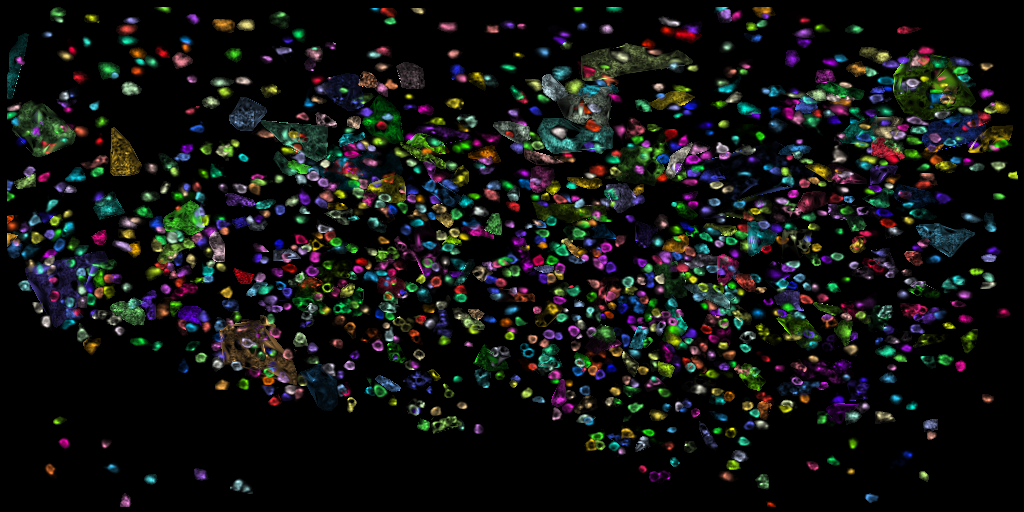

In [10]:
if use_multiple_sessions:
    FOVs_colored = roicat.visualization.compute_colored_FOV(
        spatialFootprints=results_roicat_tracking['ROIs']['ROIs_aligned'], 
        FOV_height=results_roicat_tracking['ROIs']['frame_height'], 
        FOV_width=results_roicat_tracking['ROIs']['frame_width'], 
    #     labels=results_tracking['UCIDs_bySession'], 
        labels=results_roicat_tracking['clusters']['labels_bySession'],
    )

    %matplotlib notebook

    roicat.visualization.display_toggle_image_stack(FOVs_colored)

In [15]:
n_frames, n_rois = F.shape[1], F.shape[0]
Fs = ops['fs']

In [11]:
# # Oopsie!
# # Mouse g2FB: delete 43000 - 50000 frames
# F_toUse = np.delete(F_toUse, range(43000,50000), axis=1)
# Fneu_toUse = np.delete(Fneu_toUse, range(43000,50000), axis=1)

In [12]:
percentile_baseline = 30
neuropil_fraction=0.7

dFoF , dF , F_neuSub , F_baseline = bnpm.ca2p_preprocessing.make_dFoF(
    F=F,
    Fneu=Fneu,
    neuropil_fraction=neuropil_fraction,
    percentile_baseline=percentile_baseline,
    rolling_percentile_window=None,
    multicore_pref=True,
    verbose=True,
)

Calculated dFoF. Total elapsed time: 9.23 seconds


In [13]:
win_rolling_percentile = 15*60*30

dFoF_roll , dF_roll , F_neuSub_roll , F_baseline_roll = bnpm.ca2p_preprocessing.make_dFoF(
    F=F,
    Fneu=Fneu,
    neuropil_fraction=neuropil_fraction,
    percentile_baseline=percentile_baseline,
    rolling_percentile_window=win_rolling_percentile,
    roll_centered=True,
    roll_stride=1,
    roll_interpolation='linear',
    multicore_pref=True,
    verbose=True
)

dFoF_params = {
    "channelOffset_correction": 0,
    "percentile_baseline": percentile_baseline,
    "neuropil_fraction": neuropil_fraction,
    "rolling_percentile_window": win_rolling_percentile,    
}

100%|███████████████████████████████████████████| 36/36 [00:17<00:00,  2.07it/s]


Calculated dFoF. Total elapsed time: 20.17 seconds


ROIs excluded: 1328 / 2004
ROIs included: 676 / 2004


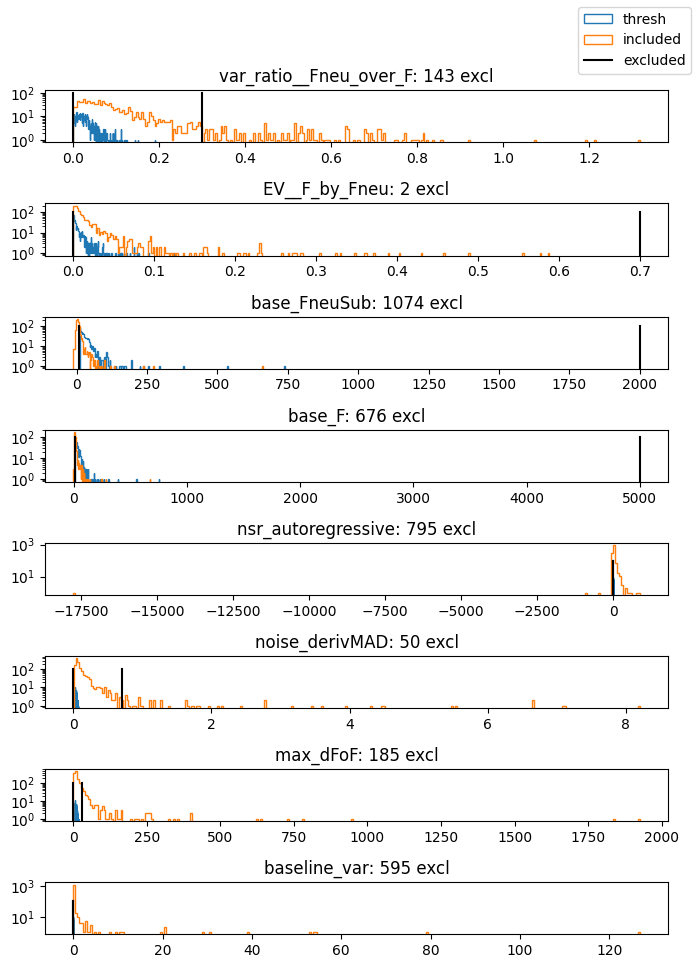

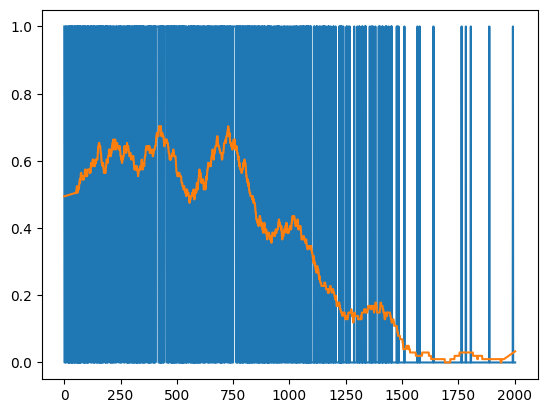

In [54]:
%matplotlib inline

thresh = {
    'var_ratio__Fneu_over_F': (0, 0.3),
    'EV__F_by_Fneu': (0, 0.7),
    'base_FneuSub': (10, 2000),
    'base_F': (10, 5000),
    'nsr_autoregressive': (0, 10),
    'noise_derivMAD': (0, 0.7),
    'max_dFoF': (0.75, 30),
    'baseline_var': (0, 0.025),
}
# thresh = {
#     'var_ratio__Fneu_over_F': np.inf,
#     'EV__F_by_Fneu': np.inf,
#     'base_FneuSub': -np.inf,
#     'base_F': -np.inf,
#     'nsr_autoregressive': np.inf,
#     'noise_derivMAD': np.inf,
#     'max_dFoF': np.inf,
#     'baseline_var': np.inf,
# }
    
tqm, iscell_tqm = bnpm.ca2p_preprocessing.trace_quality_metrics(
    F=F,
    Fneu=Fneu,
    dFoF=dFoF,
    F_neuSub=F_neuSub,
    F_baseline_roll=F_baseline_roll,

#     F=f[iscell_roicatClassification_trackingMatch[0].astype(np.bool_)],
#     Fneu=fneu[iscell_roicatClassification_trackingMatch[0].astype(np.bool_)],
#     dFoF=dfof[iscell_roicatClassification_trackingMatch[0].astype(np.bool_)],
#     F_neuSub=fneusub[iscell_roicatClassification_trackingMatch[0].astype(np.bool_)],
#     F_baseline_roll=fbs[iscell_roicatClassification_trackingMatch[0].astype(np.bool_)],

    percentile_baseline=percentile_baseline,
    Fs=Fs,
    plot_pref=True,
    thresh=thresh,
    device='cpu',
)

idxROI_tqm_toInclude = iscell_tqm
idxROI_tqm_toExclude = ~iscell_tqm

In [55]:
import rastermap

rmap = rastermap.Rastermap(n_components=1)
rmap.fit(dFoF[iscell_tqm])

nmin 200
0.09563589096069336
6.126845121383667
6.411625623703003
6.415030002593994
(38, 40)
(70,)
1.0
time; iteration;  explained PC variance
0.00s     0        0.0562      2
0.03s    10        0.1932      4
0.06s    20        0.2115      8
0.09s    30        0.2577      18
0.12s    40        0.2928      28
0.15s    50        0.3285      38
0.17s    60        0.3292      38
0.20s   final      0.3292
0.20s upsampled    0.3292


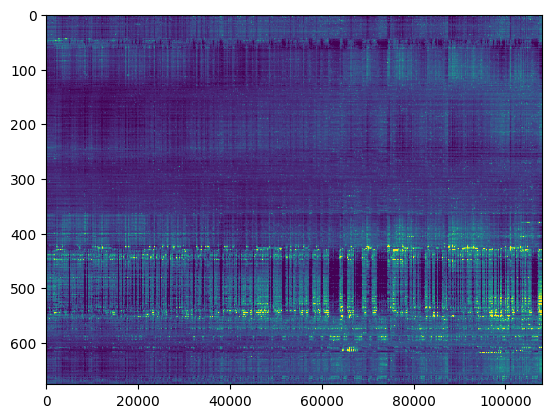

In [56]:
plt.figure()
plt.imshow(dFoF[iscell_tqm][rmap.isort], aspect='auto', vmin=-0.1, vmax=2)

In [57]:
results_roicat_tracking['ROIs']['ROIs_aligned']

[<1868x524288 sparse matrix of type '<class 'numpy.float32'>'
 	with 399743 stored elements in Compressed Sparse Row format>,
 <2004x524288 sparse matrix of type '<class 'numpy.float32'>'
 	with 466141 stored elements in Compressed Sparse Row format>]


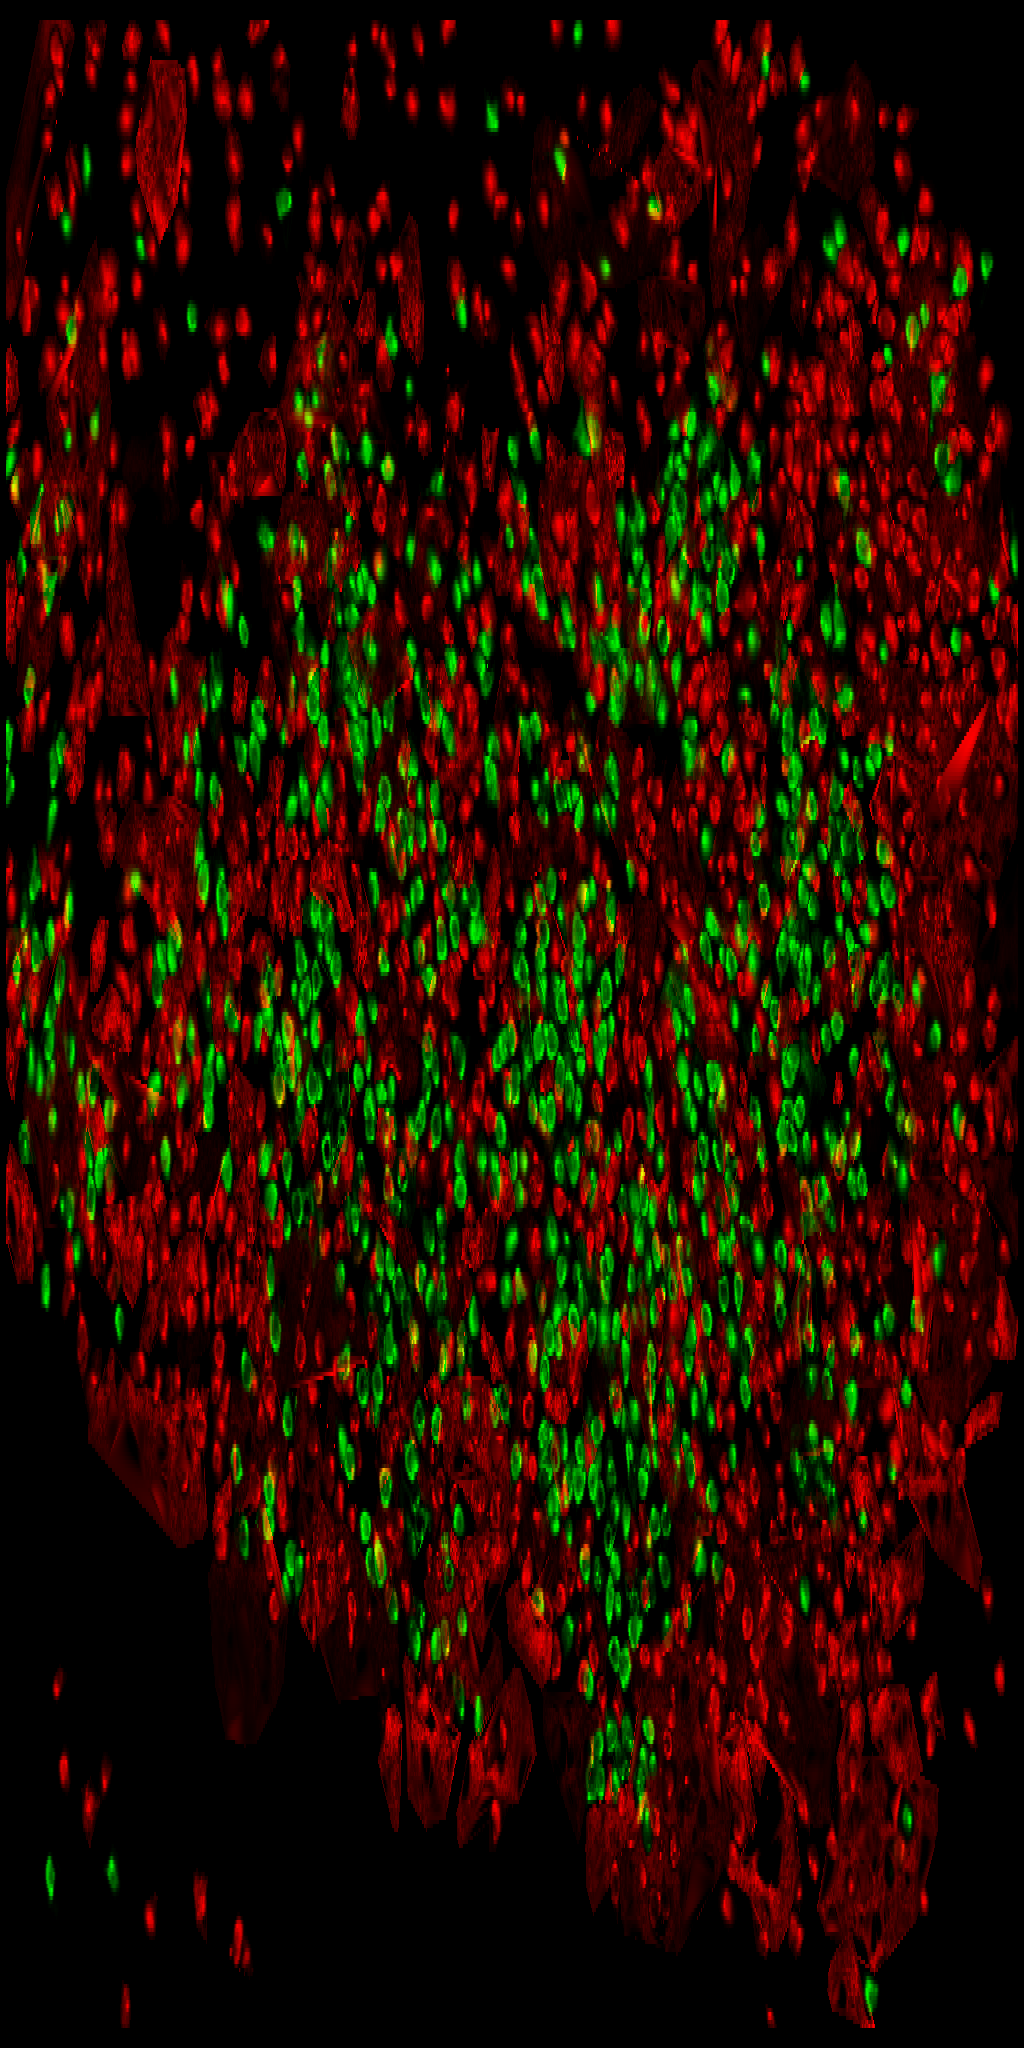

In [58]:
FOVs_colored = roicat.visualization.compute_colored_FOV(
    spatialFootprints=[results_roicat_tracking['ROIs']['ROIs_aligned'][-1]], 
    FOV_height=results_roicat_tracking['ROIs']['frame_height'], 
    FOV_width=results_roicat_tracking['ROIs']['frame_width'], 
    labels=iscell_tqm.astype(np.int64),
    cmap=roicat.helpers.simple_cmap([[1,0,0],[0,1,0]]),
)

roicat.visualization.display_toggle_image_stack(FOVs_colored, image_size=np.array(FOVs_colored[0].shape[:2])[::1]*2)

In [59]:
bnpm.file_helpers.pickle_save(
    obj={
        "tqm": tqm,
        "iscell_tqm": iscell_tqm,
#         "iscell_classifier_matching_tqm": iscell_conj,
        "dFoF_params": dFoF_params
    },
    filepath=str(Path(params['paths']['dir_save']).resolve() / 'trace_quality.pkl')
)

# bnpm.file_helpers.pickle_save(
#     obj={
#         "iscell_classifier_matching_tqm": iscell_conj,
#         "UCIDs_classifier_matching_tqm": ucids_iscell_fullMatch_tqm if use_multiple_sessions else None,
#     },
#     filepath=str(Path(params['paths']['dir_save']).resolve() / 'iscell_classifier_matching_tqm.pkl'),
# )